<a href="https://colab.research.google.com/github/ParthDave111/Quant-and-Finance-File/blob/main/CIR(1995)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
mat_list = np.array((7, 30, 90, 180, 360)) / 360
rate_list = (
    np.array((0.00648, 0.00679, 0.01173, 0.01809, 0.0256)) / 100
)

In [ ]:
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

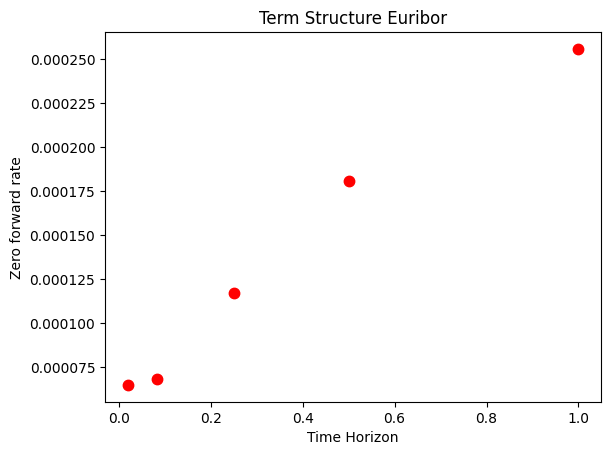

In [ ]:
plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

In [ ]:
from scipy.interpolate import splev, splrep

In [ ]:
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 24
)  # Create 24 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative
inter_rates

array([6.70843385e-05, 6.42107142e-05, 6.84848564e-05, 7.80981044e-05,
       9.12417973e-05, 1.06107274e-04, 1.20890896e-04, 1.34396671e-04,
       1.46608744e-04, 1.57646855e-04, 1.67630740e-04, 1.76680136e-04,
       1.84914782e-04, 1.92454414e-04, 1.99418770e-04, 2.05927588e-04,
       2.12100605e-04, 2.18057558e-04, 2.23918185e-04, 2.29802223e-04,
       2.35829410e-04, 2.42119483e-04, 2.48792180e-04, 2.55967238e-04])

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

In [ ]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

In [ ]:
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

In [ ]:
from scipy.optimize import fmin

In [ ]:
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=5000,
    )

    return opt

In [ ]:
params = CIR_calibration()
params

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 194
         Function evaluations: 367


array([1.1507801 , 0.00277847, 0.0799676 ])

In [ ]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

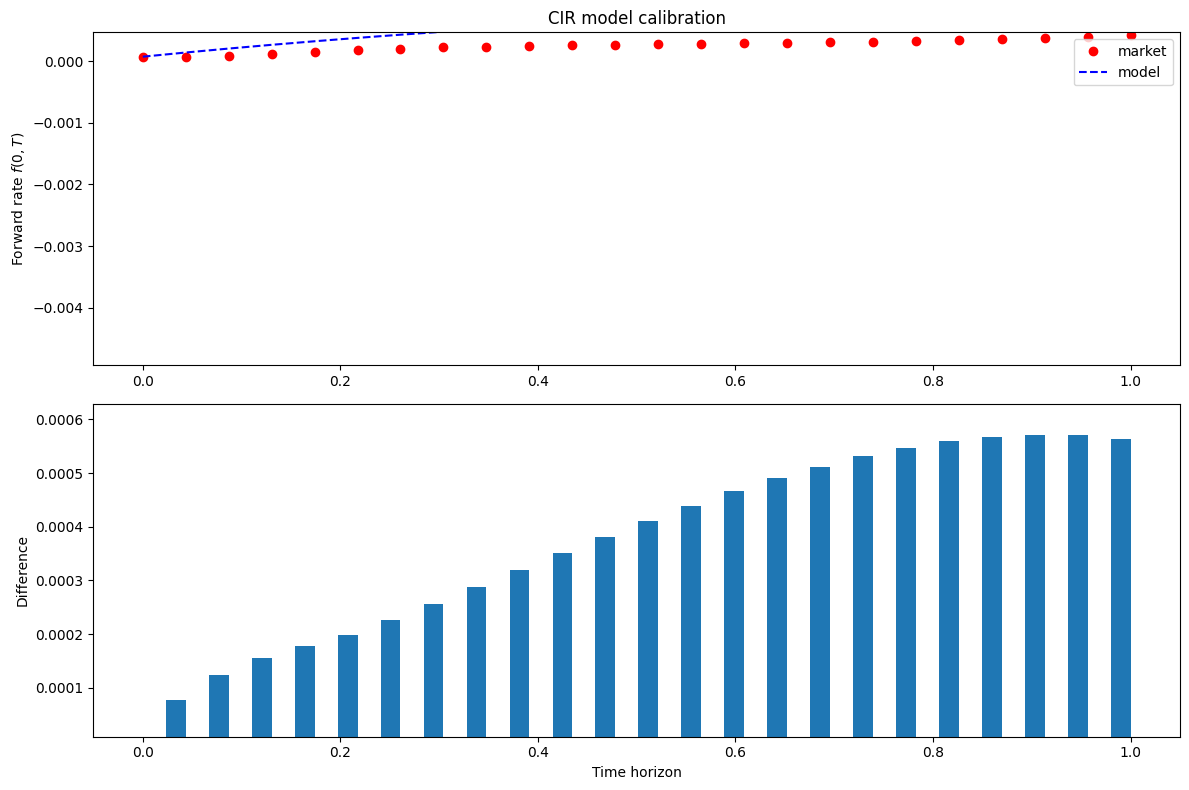

In [ ]:
plot_calibrated_frc(params)

### **STEP 3 (B)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def CIR_simulation(r0, kappa_r, theta_r, sigma_r, T, N, num_simulations):
    dt = T / N
    rates = np.zeros((num_simulations, N + 1))
    rates[:, 0] = r0
    for i in range(num_simulations):
        for j in range(N):
            rates[i, j + 1] = rates[i, j] + kappa_r * (theta_r - rates[i, j]) * dt + sigma_r * np.sqrt(rates[i, j]) * np.random.normal(0, np.sqrt(dt))

    return rates

In [ ]:
r0 = rate_list[0]  # Initial rate
kappa_r, theta_r, sigma_r = params  # CIR parameters from calibration
T = 1  # Time horizon (1 year)
N = 365  # Number of steps (daily)
num_simulations = 100000  # Number of Monte Carlo simulations

rates = CIR_simulation(r0, kappa_r, theta_r, sigma_r, T, N, num_simulations)

<ipython-input-46-2c0ffcb2d9ed>:7: RuntimeWarning: invalid value encountered in sqrt
  rates[i, j + 1] = rates[i, j] + kappa_r * (theta_r - rates[i, j]) * dt + sigma_r * np.sqrt(rates[i, j]) * np.random.normal(0, np.sqrt(dt))


95% confidence interval: [nan, nan]
Expected rate: nan


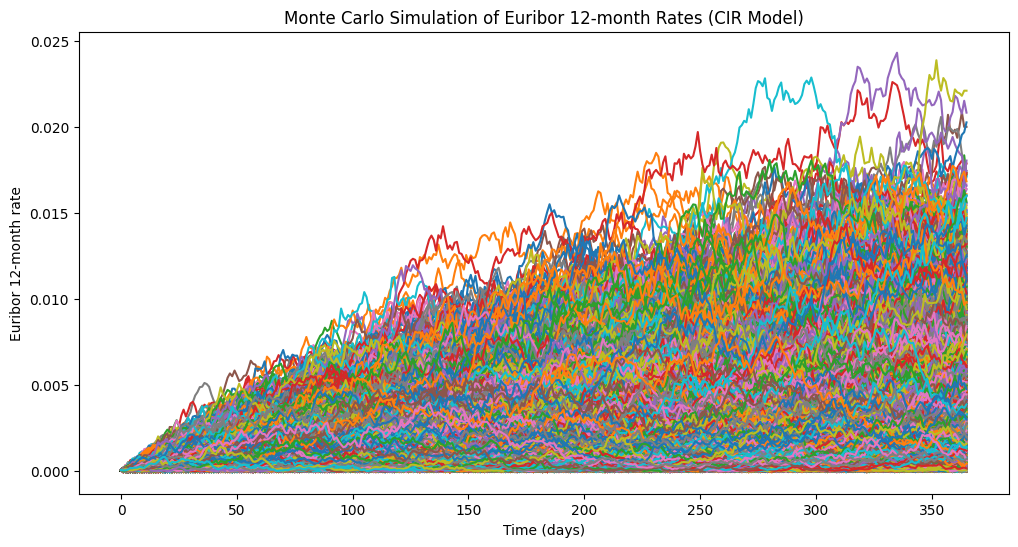

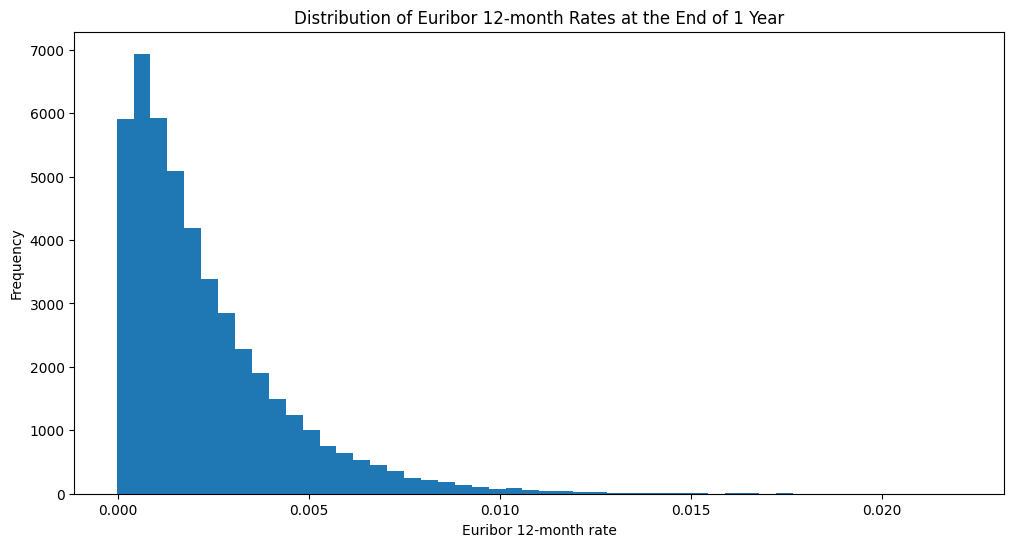

In [ ]:
# i. Confidence interval
confidence_level = 0.95  # Select your desired confidence level
lower_bound = np.percentile(rates[:, -1], (1 - confidence_level) / 2 * 100)
upper_bound = np.percentile(rates[:, -1], (1 + confidence_level) / 2 * 100)
print(f"{confidence_level * 100:.0f}% confidence interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# ii. Expected value
expected_rate = np.mean(rates[:, -1])
print(f"Expected rate: {expected_rate:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(rates.T)
plt.xlabel("Time (days)")
plt.ylabel("Euribor 12-month rate")
plt.title("Monte Carlo Simulation of Euribor 12-month Rates (CIR Model)")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(rates[:, -1], bins=50)
plt.xlabel("Euribor 12-month rate")
plt.ylabel("Frequency")
plt.title("Distribution of Euribor 12-month Rates at the End of 1 Year")
plt.show()

Resolvng NAN value issue with incremental monte carlo to do a root cause analysis and to discover actual nan value

Performing Incremental Monte Carlo SImulation

N=1

95% confidence interval: [0.0080, 0.0080]
Expected rate: 0.0080


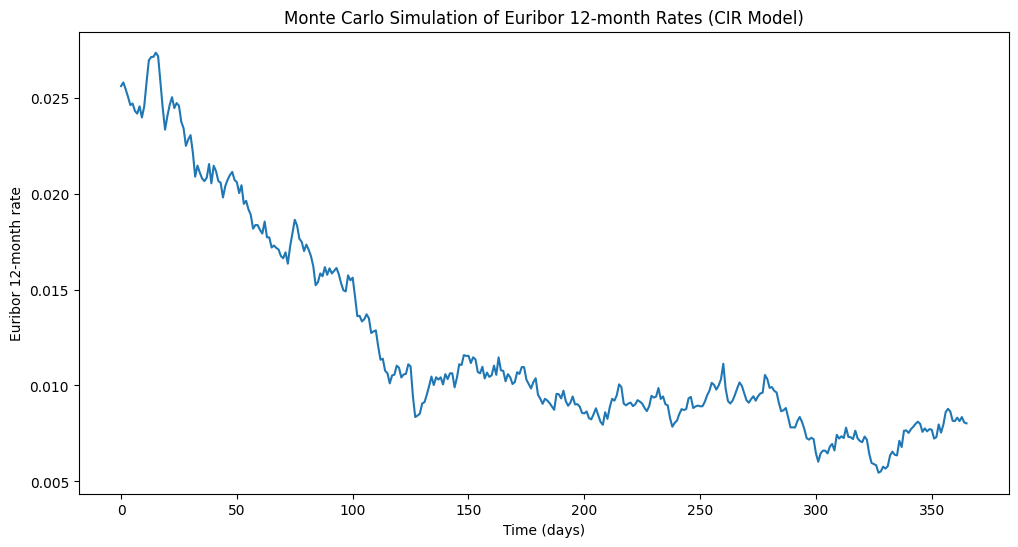

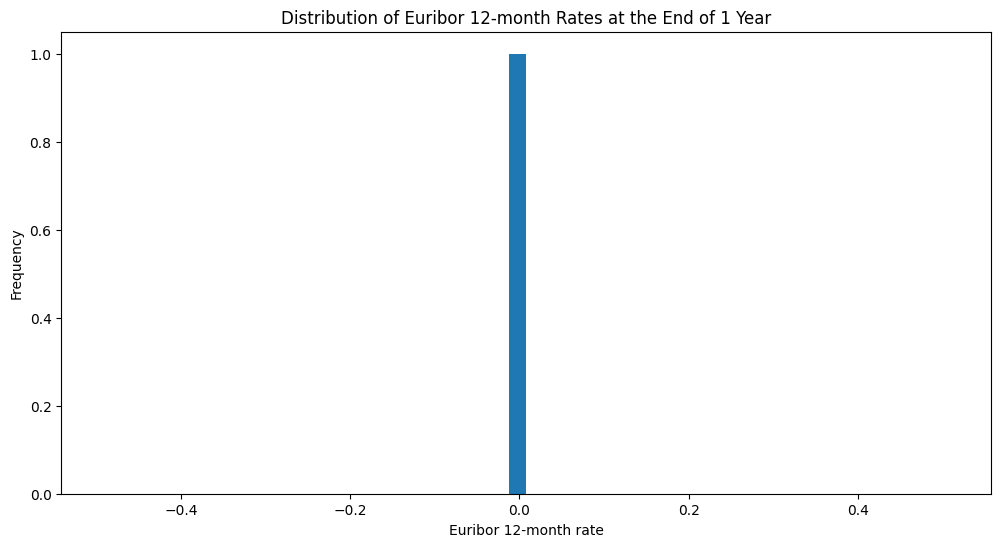

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have rate_list and params defined somewhere:
rate_list = [0.0256]  # Replace with your actual rate_list
params = (1.1507801, 0.00277847,0.0799676)  # Replace with your actual params

r0 = rate_list[0]  # Initial rate
kappa_r, theta_r, sigma_r = params  # CIR parameters from calibration
T = 1  # Time horizon (1 year)
N = 365  # Number of steps (daily)
num_simulations = 1  # Number of Monte Carlo simulations

rates = CIR_simulation(r0, kappa_r, theta_r, sigma_r, T, N, num_simulations)

# i. Confidence interval
confidence_level = 0.95  # Select your desired confidence level
lower_bound = np.percentile(rates[:, -1], (1 - confidence_level) / 2 * 100)
upper_bound = np.percentile(rates[:, -1], (1 + confidence_level) / 2 * 100)
print(f"{confidence_level * 100:.0f}% confidence interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# ii. Expected value
expected_rate = np.mean(rates[:, -1])
print(f"Expected rate: {expected_rate:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(rates.T)
plt.xlabel("Time (days)")
plt.ylabel("Euribor 12-month rate")
plt.title("Monte Carlo Simulation of Euribor 12-month Rates (CIR Model)")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(rates[:, -1], bins=50)
plt.xlabel("Euribor 12-month rate")
plt.ylabel("Frequency")
plt.title("Distribution of Euribor 12-month Rates at the End of 1 Year")
plt.show()

95% confidence interval: [0.0060, 0.0241]
Expected rate: 0.0128


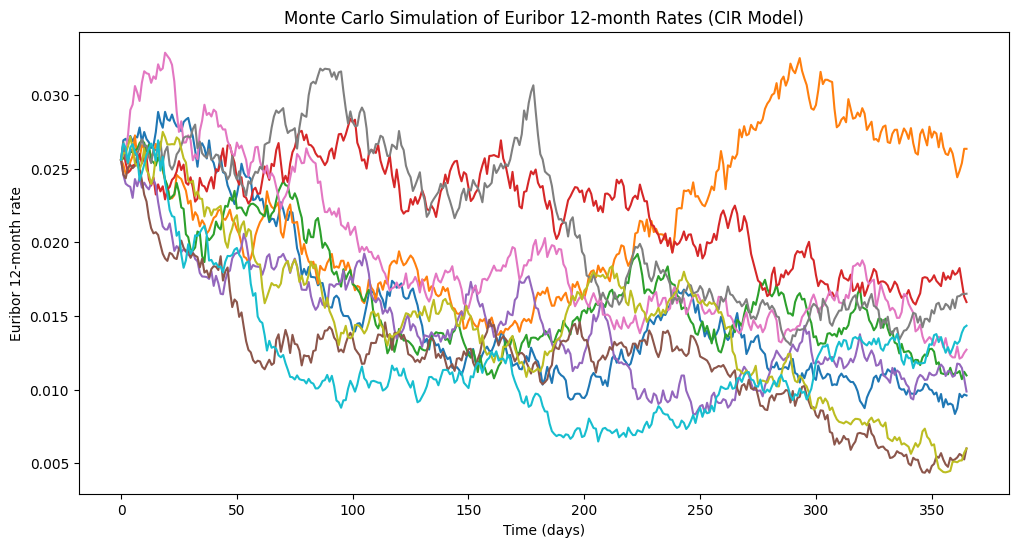

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have rate_list and params defined somewhere:
rate_list = [0.0256]  # Replace with your actual rate_list
params = (1.1507801, 0.00277847,0.0799676)  # Replace with your actual params

r0 = rate_list[0]  # Initial rate
kappa_r, theta_r, sigma_r = params  # CIR parameters from calibration
T = 1  # Time horizon (1 year)
N = 365  # Number of steps (daily)
num_simulations = 10  # Number of Monte Carlo simulations

rates = CIR_simulation(r0, kappa_r, theta_r, sigma_r, T, N, num_simulations)

# i. Confidence interval
confidence_level = 0.95  # Select your desired confidence level
lower_bound = np.percentile(rates[:, -1], (1 - confidence_level) / 2 * 100)
upper_bound = np.percentile(rates[:, -1], (1 + confidence_level) / 2 * 100)
print(f"{confidence_level * 100:.0f}% confidence interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# ii. Expected value
expected_rate = np.mean(rates[:, -1])
print(f"Expected rate: {expected_rate:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(rates.T)
plt.xlabel("Time (days)")
plt.ylabel("Euribor 12-month rate")
plt.title("Monte Carlo Simulation of Euribor 12-month Rates (CIR Model)")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(rates[:, -1], bins=50)
plt.xlabel("Euribor 12-month rate")
plt.ylabel("Frequency")
plt.title("Distribution of Euribor 12-month Rates at the End of 1 Year")
plt.show()

N=100

95% confidence interval: [0.0029, 0.0220]
Expected rate: 0.0108


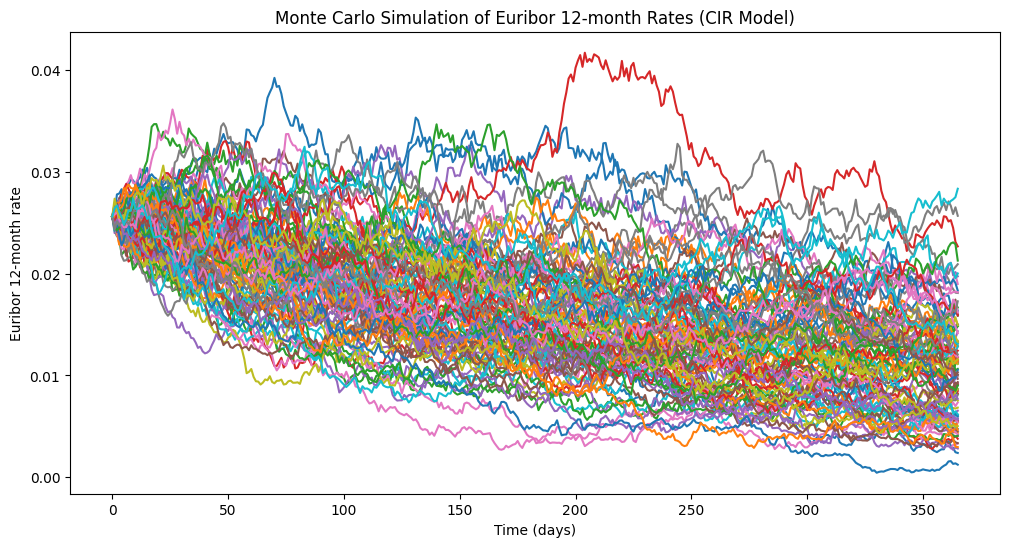

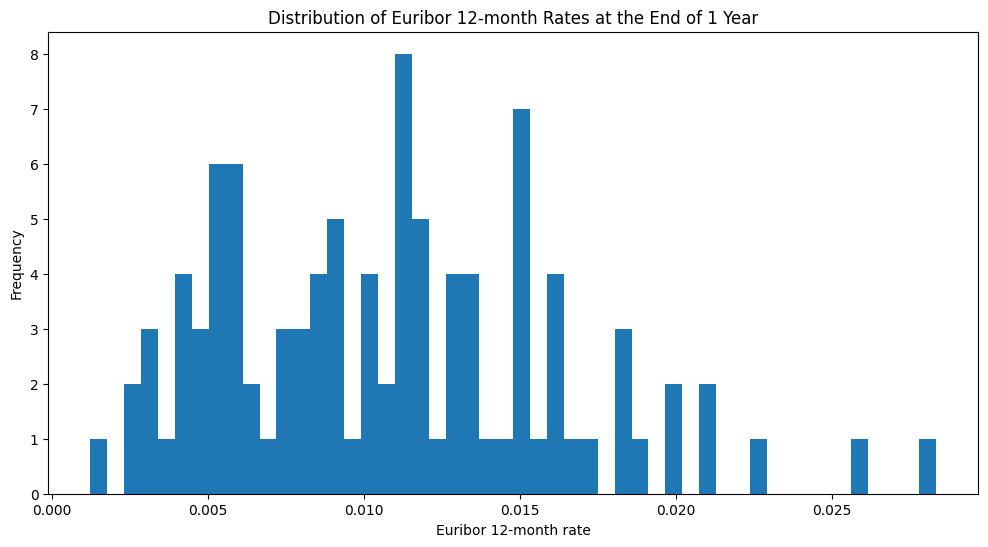

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have rate_list and params defined somewhere:
rate_list = [0.0256]  # Replace with your actual rate_list
params = (1.1507801, 0.00277847,0.0799676)  # Replace with your actual params

r0 = rate_list[0]  # Initial rate
kappa_r, theta_r, sigma_r = params  # CIR parameters from calibration
T = 1  # Time horizon (1 year)
N = 365  # Number of steps (daily)
num_simulations = 100  # Number of Monte Carlo simulations

rates = CIR_simulation(r0, kappa_r, theta_r, sigma_r, T, N, num_simulations)

# i. Confidence interval
confidence_level = 0.95  # Select your desired confidence level
lower_bound = np.percentile(rates[:, -1], (1 - confidence_level) / 2 * 100)
upper_bound = np.percentile(rates[:, -1], (1 + confidence_level) / 2 * 100)
print(f"{confidence_level * 100:.0f}% confidence interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# ii. Expected value
expected_rate = np.mean(rates[:, -1])
print(f"Expected rate: {expected_rate:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(rates.T)
plt.xlabel("Time (days)")
plt.ylabel("Euribor 12-month rate")
plt.title("Monte Carlo Simulation of Euribor 12-month Rates (CIR Model)")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(rates[:, -1], bins=50)
plt.xlabel("Euribor 12-month rate")
plt.ylabel("Frequency")
plt.title("Distribution of Euribor 12-month Rates at the End of 1 Year")
plt.show()

N = 1000

95% confidence interval: [0.0015, 0.0236]
Expected rate: 0.0099


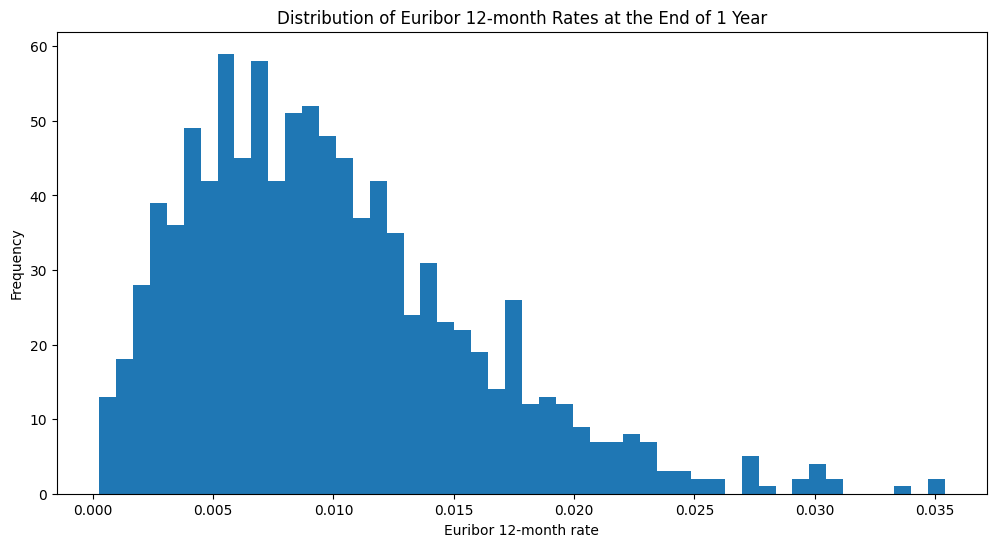

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have rate_list and params defined somewhere:
rate_list = [0.0256]  # Replace with your actual rate_list
params = (1.1507801, 0.00277847,0.0799676)  # Replace with your actual params

r0 = rate_list[0]  # Initial rate
kappa_r, theta_r, sigma_r = params  # CIR parameters from calibration

if 2 * kappa_r * theta_r < sigma_r**2:
    print("Warning: Feller condition violated. Consider adjusting parameters.")


T = 1  # Time horizon (1 year)
N = 365  # Number of steps (daily)
num_simulations = 1000  # Number of Monte Carlo simulations

rates = CIR_simulation(r0, kappa_r, theta_r, sigma_r, T, N, num_simulations)

# i. Confidence interval
confidence_level = 0.95  # Select your desired confidence level
lower_bound = np.percentile(rates[:, -1], (1 - confidence_level) / 2 * 100)
upper_bound = np.percentile(rates[:, -1], (1 + confidence_level) / 2 * 100)
print(f"{confidence_level * 100:.0f}% confidence interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# ii. Expected value
expected_rate = np.mean(rates[:, -1])
print(f"Expected rate: {expected_rate:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(rates.T)
plt.xlabel("Time (days)")
plt.ylabel("Euribor 12-month rate")
plt.title("Monte Carlo Simulation of Euribor 12-month Rates (CIR Model)")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(rates[:, -1], bins=50)
plt.xlabel("Euribor 12-month rate")
plt.ylabel("Frequency")
plt.title("Distribution of Euribor 12-month Rates at the End of 1 Year")
plt.show()

<ipython-input-18-2c0ffcb2d9ed>:7: RuntimeWarning: invalid value encountered in sqrt
  rates[i, j + 1] = rates[i, j] + kappa_r * (theta_r - rates[i, j]) * dt + sigma_r * np.sqrt(rates[i, j]) * np.random.normal(0, np.sqrt(dt))


95% confidence interval: [nan, nan]
Expected rate: nan


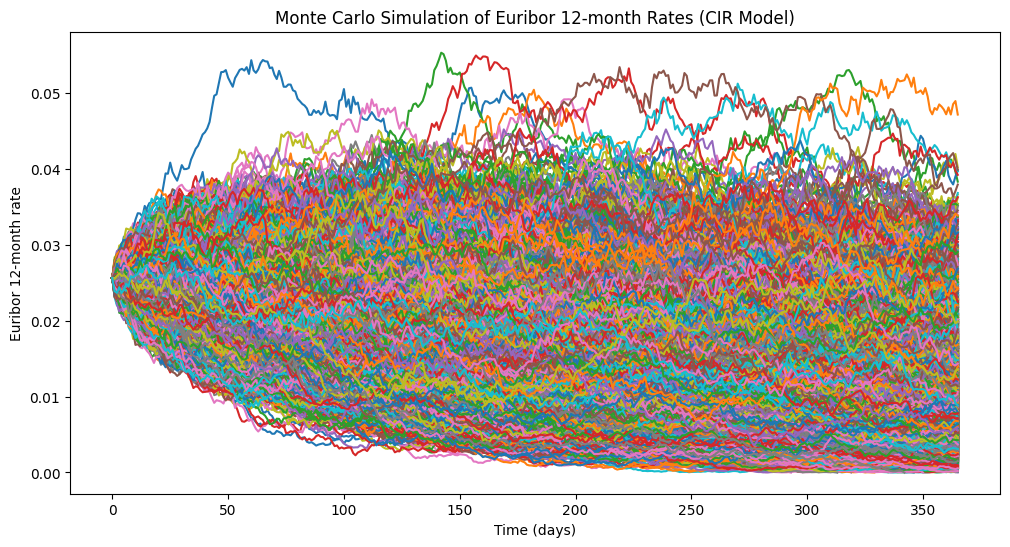

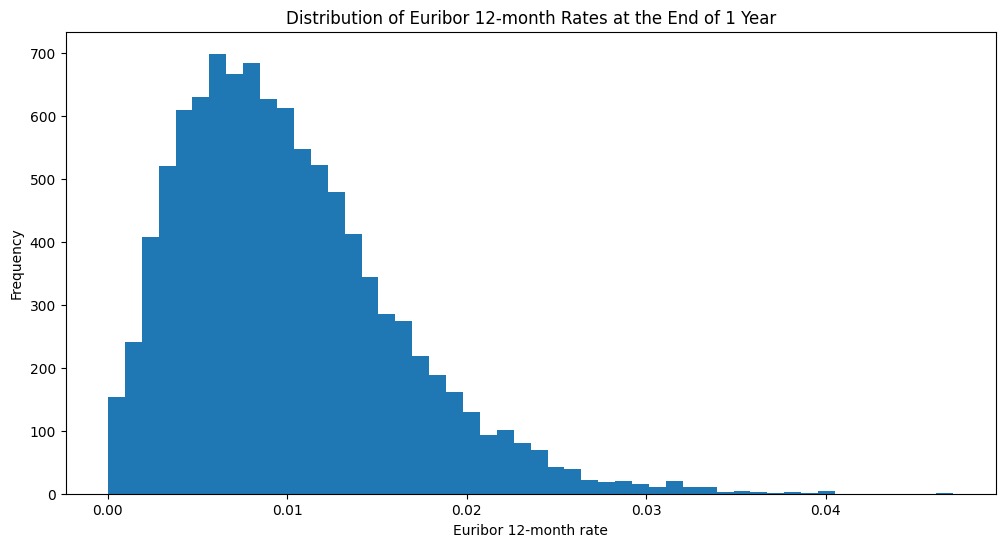

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have rate_list and params defined somewhere:
rate_list = [0.0256]  # Replace with your actual rate_list
params = (1.1507801, 0.00277847,0.0799676)  # Replace with your actual params

r0 = rate_list[0]  # Initial rate
kappa_r, theta_r, sigma_r = params  # CIR parameters from calibration

if 2 * kappa_r * theta_r < sigma_r**2:
    print("Warning: Feller condition violated. Consider adjusting parameters.")


T = 1  # Time horizon (1 year)
N = 365  # Number of steps (daily)
num_simulations = 10000  # Number of Monte Carlo simulations

rates = CIR_simulation(r0, kappa_r, theta_r, sigma_r, T, N, num_simulations)

# i. Confidence interval
confidence_level = 0.95  # Select your desired confidence level
lower_bound = np.percentile(rates[:, -1], (1 - confidence_level) / 2 * 100)
upper_bound = np.percentile(rates[:, -1], (1 + confidence_level) / 2 * 100)
print(f"{confidence_level * 100:.0f}% confidence interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# ii. Expected value
expected_rate = np.mean(rates[:, -1])
print(f"Expected rate: {expected_rate:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(rates.T)
plt.xlabel("Time (days)")
plt.ylabel("Euribor 12-month rate")
plt.title("Monte Carlo Simulation of Euribor 12-month Rates (CIR Model)")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(rates[:, -1], bins=50)
plt.xlabel("Euribor 12-month rate")
plt.ylabel("Frequency")
plt.title("Distribution of Euribor 12-month Rates at the End of 1 Year")
plt.show()

We are getting NAN value and for that we will adjust rates

In [45]:
def CIR_simulation(r0, kappa_r, theta_r, sigma_r, T, N, num_simulations):
    dt = T / N
    rates = np.zeros((num_simulations, N + 1))
    rates[:, 0] = r0
    for i in range(num_simulations):
        for j in range(N):
            # CIR model equation
            rates[i, j + 1] = rates[i, j] + kappa_r * (theta_r - rates[i, j]) * dt + sigma_r * np.sqrt(rates[i, j]) * np.random.normal(0, np.sqrt(dt))
            # Ensure the rate does not fall below the threshold, applying to the specific rate being updated
            rates[i, j + 1] = max(0.0001, rates[i, j + 1])

    return rates

95% confidence interval: [0.0015, 0.0239]
Expected rate: 0.0100


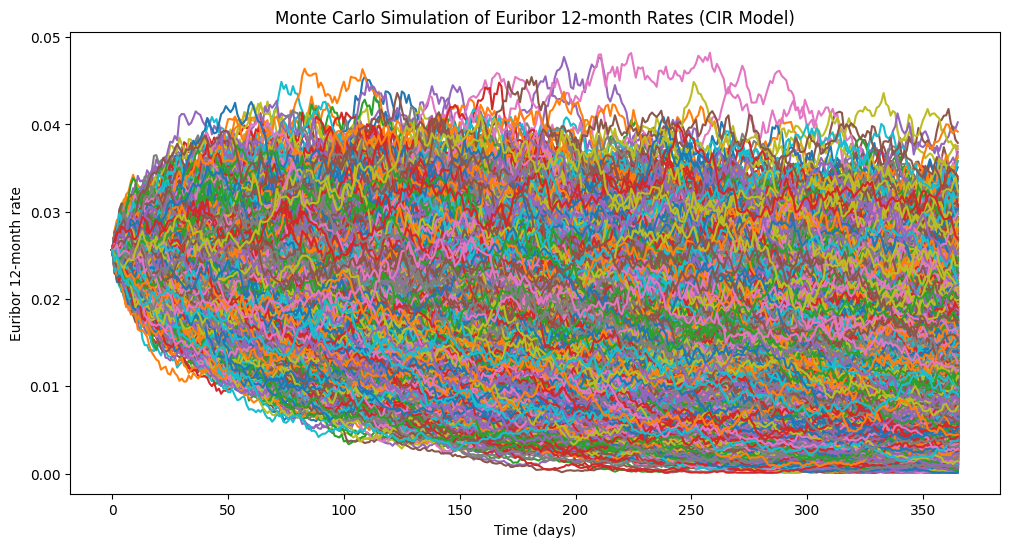

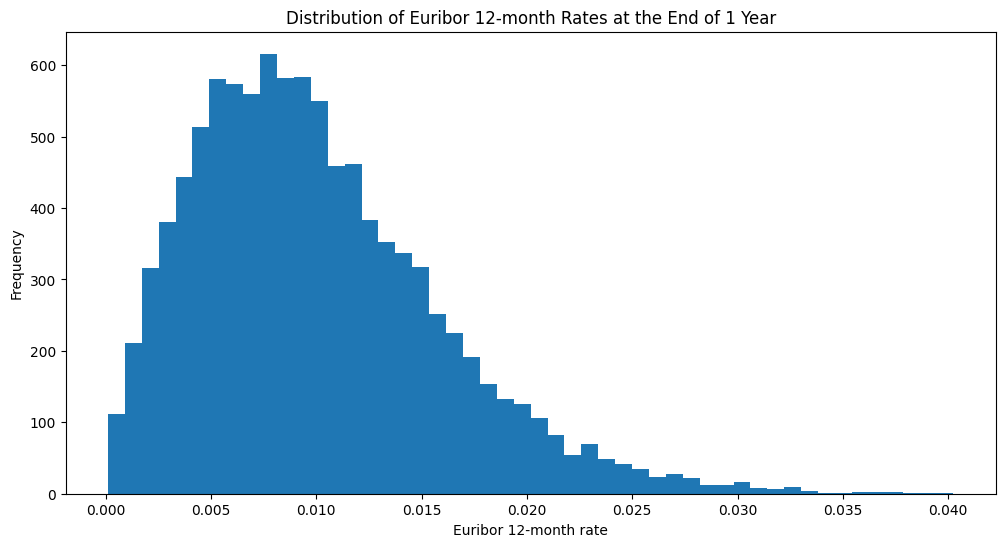

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have rate_list and params defined somewhere:
rate_list = [0.0256]  # Replace with your actual rate_list
params = (1.1507801, 0.00277847,0.0799676)  # Replace with your actual params

r0 = rate_list[0]  # Initial rate
kappa_r, theta_r, sigma_r = params  # CIR parameters from calibration

if 2 * kappa_r * theta_r < sigma_r**2:
    print("Warning: Feller condition violated. Consider adjusting parameters.")


T = 1  # Time horizon (1 year)
N = 365  # Number of steps (daily)
num_simulations = 10000  # Number of Monte Carlo simulations

rates = CIR_simulation(r0, kappa_r, theta_r, sigma_r, T, N, num_simulations)

# i. Confidence interval
confidence_level = 0.95  # Select your desired confidence level
lower_bound = np.percentile(rates[:, -1], (1 - confidence_level) / 2 * 100)
upper_bound = np.percentile(rates[:, -1], (1 + confidence_level) / 2 * 100)
print(f"{confidence_level * 100:.0f}% confidence interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# ii. Expected value
expected_rate = np.mean(rates[:, -1])
print(f"Expected rate: {expected_rate:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(rates.T)
plt.xlabel("Time (days)")
plt.ylabel("Euribor 12-month rate")
plt.title("Monte Carlo Simulation of Euribor 12-month Rates (CIR Model)")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(rates[:, -1], bins=50)
plt.xlabel("Euribor 12-month rate")
plt.ylabel("Frequency")
plt.title("Distribution of Euribor 12-month Rates at the End of 1 Year")
plt.show()

95% confidence interval: [0.0014, 0.0238]
Expected rate: 0.0100


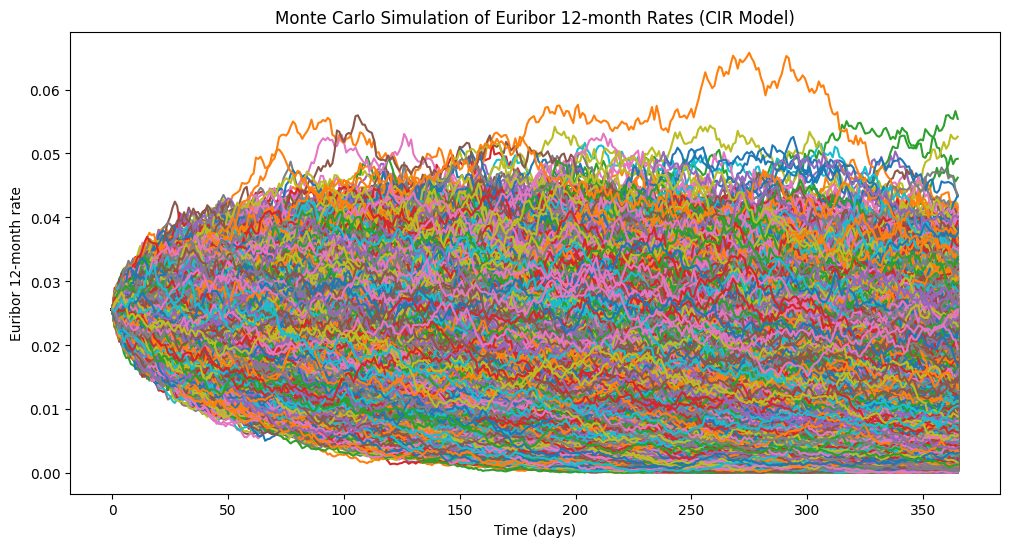

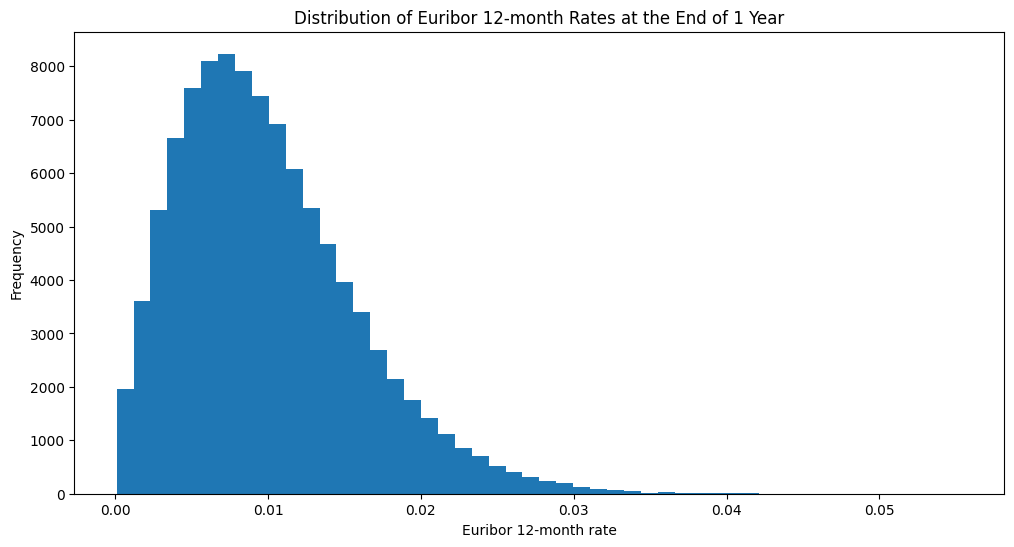

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have rate_list and params defined somewhere:
rate_list = [0.0256]  # Replace with your actual rate_list
params = (1.1507801, 0.00277847,0.0799676)  # Replace with your actual params

r0 = rate_list[0]  # Initial rate
kappa_r, theta_r, sigma_r = params  # CIR parameters from calibration

if 2 * kappa_r * theta_r < sigma_r**2:
    print("Warning: Feller condition violated. Consider adjusting parameters.")


T = 1  # Time horizon (1 year)
N = 365  # Number of steps (daily)
num_simulations = 100000  # Number of Monte Carlo simulations

rates = CIR_simulation(r0, kappa_r, theta_r, sigma_r, T, N, num_simulations)

# i. Confidence interval
confidence_level = 0.95  # Select your desired confidence level
lower_bound = np.percentile(rates[:, -1], (1 - confidence_level) / 2 * 100)
upper_bound = np.percentile(rates[:, -1], (1 + confidence_level) / 2 * 100)
print(f"{confidence_level * 100:.0f}% confidence interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# ii. Expected value
expected_rate = np.mean(rates[:, -1])
print(f"Expected rate: {expected_rate:.4f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(rates.T)
plt.xlabel("Time (days)")
plt.ylabel("Euribor 12-month rate")
plt.title("Monte Carlo Simulation of Euribor 12-month Rates (CIR Model)")
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(rates[:, -1], bins=50)
plt.xlabel("Euribor 12-month rate")
plt.ylabel("Frequency")
plt.title("Distribution of Euribor 12-month Rates at the End of 1 Year")
plt.show()